<a href="https://colab.research.google.com/github/krishnanpc/IAS_Materials/blob/master/Covid_19_model_memoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readme

readme
lstmcorona
This is LSTM to predict the growth of COVID-19 pandemics
The link of paper : https://arxiv.org/pdf/2005.04809.pdf

Before using please download the dataset here:
https://github.com/datasets/covid-19/tree/master/data

Please modify the data pre-processing by yourself, for example if the duration of each sample is more than 100 days, you should modify the "split_sequences" function inside the code such that the proportion of input and label is around 75:25 or 70:30


In [0]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import random
from scipy.interpolate import UnivariateSpline  
import pickle
from sklearn.decomposition import PCA
import time
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 30 # number of hidden states
        self.n_layers = 4 # number of LSTM layers (stacked)
        self.dropout = nn.Dropout(0.1) 

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True
                                 )
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 100)
        self.sigmoid = nn.Sigmoid()
     
        


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        #lstm_out, self.hidden = self.l_lstm(x)
        
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.sigmoid(self.l_linear(x))

In [0]:
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    
    for i in range(0,len(sequences),100):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if i!=0 and end_ix > len(sequences):
            break
        
        sequences[i:end_ix,0]=np.insert(np.diff(sequences[i:end_ix,0]),0,0)
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-30], sequences[end_ix-30:end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [0]:
#read training data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv', skiprows=1)
df.head()
df.info()
df.columns = ['day','country', 'territory', 'lat','long','confirmed','recovered','deaths']

is_china =  (df['country']=='China')

#read testing data
df2 = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv', skiprows=1)
df2.head()
df2.info()
df2.columns = ['day','country', 'territory', 'lat','long','confirmed','recovered','deaths']

is_indonesia =  (df2['country']=='Indonesia')

#training data filtering
data=df[df.country.isin(['China','Germany','Australia','Brazil','US','Belgium','Spain','Italy','UK','France','Japan','Malaysia','Vietnam','Iran','UEA','Singapore','Thailand','Korea, South','Japan','Iran','Netherlands','Russia','Chile','India','Greece','Mexico','Mongolia','Philippines','New Zealand','South Africa','Botswana','Uruguay','Paraguay','Madagascar','Peru', 'Portugal', 'Denmark','Hungary','Kenya','Ireland','Israel','Norway','Mauritius','Rwanda','Iceland','Kazakhstan','Switzerland','Cyprus','Zimbabwe'])][['confirmed','lat','long','recovered','deaths']]


#testing data filtering
data2=df2[(is_indonesia)][['confirmed','lat','long','recovered','deaths']]
date=df2[(is_indonesia)][['day','confirmed']]

date.day = pd.to_datetime(date.day,format='%Y%m%d', errors='ignore')
date.set_index('day', inplace=True)

n_features = 5 # this is number of parallel inputs
n_timesteps = 100 # this is number of timesteps


#input splitting
X, Y = split_sequences(data.values, n_timesteps)

print (X.shape,Y.shape)

#normalization
alld=np.concatenate((X,Y),1)
alld=alld.reshape(alld.shape[0]*alld.shape[1],alld.shape[2])



scaler = MinMaxScaler()
scaler.fit(alld)
X=[scaler.transform(x) for x in X]
y=[scaler.transform(y) for y in Y]

X=np.array(X)
y=np.array(y)[:,:,0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37112 entries, 0 to 37111
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   2020-01-22   37112 non-null  object 
 1   Afghanistan  37112 non-null  object 
 2   Unnamed: 2   11398 non-null  object 
 3   33.0         37112 non-null  float64
 4   65.0         37112 non-null  float64
 5   0            36973 non-null  float64
 6   0.1          35166 non-null  float64
 7   0.2          36973 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37112 entries, 0 to 37111
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   2020-01-22   37112 non-null  object 
 1   Afghanistan  37112 non-null  object 
 2   Unnamed: 2   11398 non-null  object 
 3   33.0         37112 non-null  float64
 4   65.0         37112 non-null  float64
 5   0            

In [0]:
#training

mv_net = MV_LSTM(n_features,70).cuda()
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-3)

train_episodes = 100

batch_size = 16

mv_net.train()

for t in range(train_episodes):
    
    for b in range(0,len(X),batch_size):
       
        p = np.random.permutation(len(X))
        
        inpt = X[p][b:b+batch_size,:,:]
        target = y[p][b:b+batch_size,:]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32).cuda()    
        y_batch = torch.tensor(target,dtype=torch.float32).cuda()
       
        mv_net.init_hidden(x_batch.size(0))
        
        output = mv_net(x_batch) 
        
        
        all_batch=torch.cat((x_batch[:,:,0], y_batch), 1)
        
        
        loss = 1000*criterion(output.view(-1), all_batch.view(-1))  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())


In [0]:
#evaluation#########################################################################################################
#data2x=data2[~(data2.confirmed==0)]
data2x=data2
truth = data2

data2x.values[0:len(data2x),0]=np.insert(np.diff(data2x.values[0:len(data2x),0]),0,0)
data2x=scaler.transform(data2x) 


X_test = np.expand_dims(data2x, axis=0)
print (X_test.shape)
mv_net.init_hidden(1)


lstm_out = mv_net(torch.tensor(X_test[:,-70:,:],dtype=torch.float32).cuda())
lstm_out=lstm_out.reshape(1,100,1).cpu().data.numpy()

print (data2x[-70:,0],lstm_out)
actual_predictions = scaler.inverse_transform(np.tile(lstm_out, (1, 1,5))[0])[:,0]

print (data2.values[-70:,0],actual_predictions)

#actual_predictions=lstm_out


x = np.arange(0, 54, 1)
x2 = np.arange(0, 70, 1)
x3 = np.arange(0, 100, 10)
x4 = np.arange(0, 50, 1)


#save prediction
#with open('./lstmdata/predict_indo8.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   # pickle.dump(pd.Series(actual_predictions), f,protocol=2)

(1, 139, 5)
[0.98193667 0.9819542  0.98193617 0.98197773 0.98193267 0.98197022
 0.98198875 0.98200327 0.98198875 0.98204834 0.98198925 0.98204483
 0.98207938 0.98203782 0.9820208  0.98202831 0.98206987 0.98208339
 0.98204233 0.98204333 0.98197222 0.98206736 0.9820213  0.98205835
 0.98209791 0.98207788 0.98201729 0.98198675 0.98208739 0.98200978
 0.98205334 0.98209641 0.9820258  0.98205434 0.98207738 0.98212194
 0.98206336 0.98204884 0.98204783 0.98214648 0.98207337 0.98199626
 0.98212194 0.98222459 0.982164   0.98212495 0.98214448 0.98212445
 0.98212795 0.98212294 0.9822266  0.9823668  0.98219705 0.98235478
 0.98214297 0.98211944 0.98208739 0.98222309 0.98222359 0.98221908
 0.9821585  0.9822301  0.98211343 0.98218453 0.98222209 0.98217252
 0.9822316  0.98237681 0.98221608 0.98230371] [[[0.99997973]
  [0.9999794 ]
  [0.9999802 ]
  [0.99998415]
  [0.99998176]
  [0.99998057]
  [0.9999778 ]
  [0.9999808 ]
  [0.99998033]
  [0.9999807 ]
  [0.9999814 ]
  [0.9999808 ]
  [0.99997807]
  [0.99998

Index(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
       ...
       '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03',
       '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08'],
      dtype='object', name='day', length=139)
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08'],
              dtype='datetime64[ns]', length=139, freq='D')
(139, 1)


ValueError: ignored

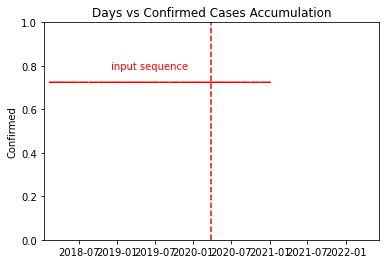

In [0]:
#visualization  
fig, ax = plt.subplots() 
plt.title('Days vs Confirmed Cases Accumulation')
plt.ylabel('Confirmed')

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

print (date.index)
date_list=pd.date_range(start=date.index[0],end=date.index[-1])
print (date_list)

plt.axvline(x=np.array(date_list)[66], color='r', linestyle='--')

ax.text(0.2*(left+right), 0.8*(bottom+top), 'input sequence',
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=10, color='red',
        transform=ax.transAxes)
ax.text(0.0125*(left+right), 0.77*(bottom+top), '______________________',
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=20, color='red',
        transform=ax.transAxes)



sumpred=np.cumsum(np.absolute(actual_predictions))

print (date.values.shape)  
print (sqrt(mean_squared_error(date.confirmed,sumpred)))          
#plt.plot(date.values[-67:],np.cumsum(data2.confirmed.values[-67:]))
plt.plot(np.array(date_list),sumpred,label='Prediction')
plt.plot(np.array(date_list),date.confirmed,label='Actual')
plt.xticks(rotation=90)
fig.autofmt_xdate()
plt.legend(loc=2)
plt.show() 